# <center> Most Expensive Neighborhoods and Areas in Berlin </center>
### <center> Berlin: arm aber sexy </center>

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)



## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to find out where in Berlin have the highest rent *in the next a few years*. Specifically, this report will be targeted to stakeholders interested in investing an appartment house in Berlin, Germany.

We will try to detect **locations that currently have the highest rent** as well as **locations that have or are expected to have the fastest rent growth**. 

We will use our data to generate a few most promissing neighborhoods and areas based on these criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* the current regional average monthly rents per square meter for an apartment exclusive of heating and other additional costs in neighborhoods/areas of Berlin;
* the growth of the regional average monthly rents per square meter for an apartment exclusive of heating and other additional costs in neighborhoods/areas of Berlin.

While it is easy to find out the average rent for each borough, it is not easy to find out the average rent of a specific area, e.g. the average rent within a radius of 500 m from Berlin-Alexanderplatz. Also it is relatively easy to collect data showing the growth of the average rent of each borough over the years, but it is not easy to get those data for each neighborhood/area. We are going to analyse the collected data for Berlin boroughs and some indirectly related data for the neighborhoods and areas to estimate the more specific rents and their growth. 

Following data sources will be needed to extract/generate the desired information:
* general information about Berlin boroughs and neighborhoods will be exacted from the Wikipedia site [Verwaltungsgliederung Berlins](https://de.wikipedia.org/wiki/Verwaltungsgliederung_Berlins) through web scraping;
* everage rent of each borough of Berlin from 2009 to 2020 will be extracted from pdf documents on the government website [Berliner Wohnungsmarktbericht](https://www.stadtentwicklung.berlin.de/wohnen/wohnungsmarktbericht/);
* demographic data about the population of each borough of Berlin from 2010 to 2019 will be extracted from pdf documents on the government website [Berliner Wohnungsmarktbericht](https://www.stadtentwicklung.berlin.de/wohnen/wohnungsmarktbericht/);
* coordinate of Berlin center and the center of each borough of Berlin will be obtained using the **Nominatim API**;
* **FourSquare API** will be used to get the details and types of venues in the vicinity of a neighborhood of Berlin.

### General Information about Boroughs and Neighborhoods of Berlin

Let's start with installing the necessary packages that we are going to use later on.

In [1]:
!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
!pip install folium
import folium # map rendering library
from bs4 import BeautifulSoup # this module helps in web scraping.
import requests  # this module helps us to download a web page
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn import linear_model
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans

Then we can start webscraping. We'll get some general information about boroughs and neighborhoods of Berlin by scraping the Wikipedia site [Verwaltungsgliederung Berlins](https://de.wikipedia.org/wiki/Verwaltungsgliederung_Berlins).

In [2]:
url = 'https://de.wikipedia.org/wiki/Verwaltungsgliederung_Berlins'
data  = requests.get(url).text 
soup = BeautifulSoup(data, 'html5lib')
table = soup.find('table')
table_rows = table.find_all('tr')
table_contents=[]
for i in range(1,len(table_rows)):
    row = table_rows[i].findAll('td')
    cell = {}
    cell['Borough'] = row[1].b.span.text.strip('\n')
    if i < 10:
         cell['Neighborhood'] = row[2].text.replace('0'+str(i)+'01 ','').replace('0'+str(i)+'02 ',', ').replace('0'+str(i)+'03 ',', ').replace('0'+str(i)+'04 ',', ').replace('0'+str(i)+'05 ',', ').replace('0'+str(i)+'06 ',', ').replace('0'+str(i)+'07 ',', ').replace('0'+str(i)+'08 ',', ').replace('0'+str(i)+'09 ',', ').replace('0'+str(i)+'10 ',', ').replace('0'+str(i)+'11 ',', ').replace('0'+str(i)+'12 ',', ').replace('0'+str(i)+'13 ',', ').replace('0'+str(i)+'14 ',', ').replace('0'+str(i)+'15 ',', ').strip('\n')
    else:
         cell['Neighborhood'] = row[2].text.replace(str(i)+'01 ','').replace(str(i)+'02 ',', ').replace(str(i)+'03 ',', ').replace(str(i)+'04 ',', ').replace(str(i)+'05 ',', ').replace(str(i)+'06 ',', ').replace(str(i)+'07 ',', ').replace(str(i)+'08 ',', ').replace(str(i)+'09 ',', ').replace(str(i)+'10 ',', ').replace(str(i)+'11 ',', ').replace(str(i)+'12 ',', ').replace(str(i)+'13 ',', ').replace(str(i)+'14 ',', ').replace(str(i)+'15 ',', ').strip('\n')
    cell['Area'] = row[3].text.strip('\n').replace(',', '')
    cell['Population'] = row[4].text.strip('\n').replace(',', '')
    cell['Density'] = row[5].text.strip('\n').replace(',', '')
    table_contents.append(cell)

# print(table_contents)
df = pd.DataFrame(table_contents)
df[['Population','Area','Density']] = df[['Population','Area','Density']].astype(float)
df

,Borough,Neighborhood,Area,Population,Density
0,Mitte,"Mitte, Moabit, Hansaviertel, Tiergarten, Weddi...",3947.0,385.748,9.773
1,Friedrichshain-Kreuzberg,"Friedrichshain, Kreuzberg",2016.0,290.386,14.404
2,Pankow,"Prenzlauer Berg, Weißensee, Blankenburg, Heine...",10301.0,409.335,3.974
3,Charlottenburg-Wilmersdorf,"Charlottenburg, Wilmersdorf, Schmargendorf, Gr...",6472.0,343.592,5.309
4,Spandau,"Spandau, Haselhorst, Siemensstadt, Staaken, Ga...",9191.0,245.197,2.668
5,Steglitz-Zehlendorf,"Steglitz, Lichterfelde, Lankwitz, Zehlendorf, ...",10250.0,310.071,3.025
6,Tempelhof-Schöneberg,"Schöneberg, Friedenau, Tempelhof, Mariendorf, ...",5309.0,350.984,6.611
7,Neukölln,"Neukölln, Britz, Buckow, Rudow, Gropiusstadt",4493.0,329.917,7.343
8,Treptow-Köpenick,"Alt-Treptow, Plänterwald, Baumschulenweg, Joha...",16842.0,273.689,1.625
9,Marzahn-Hellersdorf,"Marzahn, Biesdorf, Kaulsdorf, Mahlsdorf, Helle...",6174.0,269.967,4.373


Let's get of the rent of each borough of Berlin from 2009 to 2020 from the pdf files on the website [Berliner Wohnungsmarktbericht](https://www.stadtentwicklung.berlin.de/wohnen/wohnungsmarktbericht/).

In [3]:
Berlin = df.append({'Borough':'Berlin'},ignore_index=True).Borough.values.tolist()
Bezirke = Berlin[:]
Bezirke.remove('Berlin')

In [4]:
Berlin_Mieten = pd.DataFrame([[13.70, 13.11, 10.50, 12.38, 8.53, 10.31, 9.97, 9.38, 10.19, 8.02, 9.08, 8.84, 10.14],
                      [13.45, 13.01, 10.96, 12.63, 8.86, 10.70, 10.52, 10.10, 9.93, 7.90, 9.27, 9.42, 10.45],
                      [12.51, 12.94, 10.97, 12.00, 8.59, 10.44, 10.30, 10.00, 9.62, 7.77, 9.53, 9.17, 10.32],
                      [12.77, 12.50, 10.86, 11.86, 7.95, 10.00, 9.97, 10.00, 9.16, 7.16, 9.72, 8.73, 10.15],
                      [10.51, 11.50, 9.99, 10.53, 7.35, 9.38, 9.00, 9.00, 8.24, 6.51, 8.80, 8.00, 9.07],
                      [10.06, 10.99, 9.45, 10.00, 6.99, 8.87, 8.50, 8.57, 7.81, 5.76, 8.10, 7.50, 8.80],
                      [9.36, 9.98, 8.99, 9.49, 6.58, 8.50, 8.01, 7.73, 7.12, 5.80, 7.50, 6.92, 8.25],
                      [9.39, 9.64, 8.56, 9.86, 6.48, 8.50, 8.00, 7.33, 7.08, 5.55, 7.01, 6.86, 8.05],
                      [8.03, 8.61, 8.00, 8.93, 5.93, 7.99, 7.49, 6.70, 6.55, 5.08, 6.53, 6.31, 7.40],
                      [6.18, 7.00, 6.73, 7.53, 5.28, 6.88, 6.23, 5.57, 5.80, 4.85, 5.65, 5.49, 6.17],
                      [5.37, 6.42, 6.13, 6.56, 5.26, 6.29, 5.84, 5.19, 5.55, 4.86, 5.51, 5.26, 5.82]],
                      columns=Berlin)
Berlin_Mieten['Year'] = [2020-i for i in range(0,9)]+[2010,2009]
new_columns = ['Year'] + Berlin
Berlin_Mieten = Berlin_Mieten[new_columns].sort_values(['Year'],ascending=True).reset_index(drop=True)
Berlin_Mieten

,Year,Mitte,Friedrichshain-Kreuzberg,Pankow,Charlottenburg-Wilmersdorf,Spandau,Steglitz-Zehlendorf,Tempelhof-Schöneberg,Neukölln,Treptow-Köpenick,Marzahn-Hellersdorf,Lichtenberg,Reinickendorf,Berlin
0,2009,5.37,6.42,6.13,6.56,5.26,6.29,5.84,5.19,5.55,4.86,5.51,5.26,5.82
1,2010,6.18,7.00,6.73,7.53,5.28,6.88,6.23,5.57,5.80,4.85,5.65,5.49,6.17
2,2012,8.03,8.61,8.00,8.93,5.93,7.99,7.49,6.70,6.55,5.08,6.53,6.31,7.40
3,2013,9.39,9.64,8.56,9.86,6.48,8.50,8.00,7.33,7.08,5.55,7.01,6.86,8.05
4,2014,9.36,9.98,8.99,9.49,6.58,8.50,8.01,7.73,7.12,5.80,7.50,6.92,8.25
5,2015,10.06,10.99,9.45,10.00,6.99,8.87,8.50,8.57,7.81,5.76,8.10,7.50,8.80
6,2016,10.51,11.50,9.99,10.53,7.35,9.38,9.00,9.00,8.24,6.51,8.80,8.00,9.07
7,2017,12.77,12.50,10.86,11.86,7.95,10.00,9.97,10.00,9.16,7.16,9.72,8.73,10.15
8,2018,12.51,12.94,10.97,12.00,8.59,10.44,10.30,10.00,9.62,7.77,9.53,9.17,10.32
9,2019,13.45,13.01,10.96,12.63,8.86,10.70,10.52,10.10,9.93,7.90,9.27,9.42,10.45


Let's take a preview of the data.

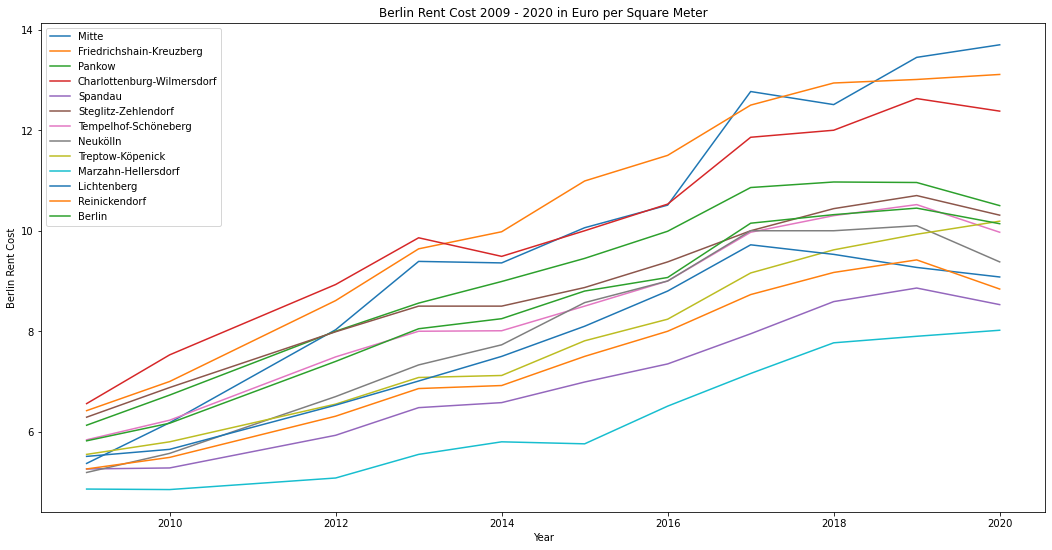

In [5]:
plt.figure(figsize = (18,9))
plt.plot(Berlin_Mieten['Year'], Berlin_Mieten[Berlin])
plt.title('Berlin Rent Cost 2009 - 2020 in Euro per Square Meter')
plt.xlabel('Year')
plt.ylabel('Berlin Rent Cost')
plt.legend(Berlin)
plt.show()

The green line is the average rent of the whole of Berlin. Apparently, the three Boroughs Berlin-Mitte, Berlin-Friedrichshain-Kreuzberg, Berlin-Charlottenburg-Wilmersdorf are above average, and the others are below average.

Now let's collect the demographic data about the population of each borough of Berlin from 2010 to 2019 from the same source.

In [6]:
Year = [2010+i for i in range(0,10)]
Berlin_Einwohner = pd.DataFrame([[326650, 333152, 339974, 348102, 356506, 363236, 371407, 377965, 383457, 385748],
                      [261090, 265361, 269471, 273517, 275691, 278393, 281323, 283974, 289120, 290386],
                      [360017, 365021, 370937, 377532, 384367, 389976, 397406, 402289, 407289, 409335],
                      [312340, 314911, 319289, 322870, 326354, 330468, 336249, 338831, 341327, 343592],
                      [218094, 220645, 223305, 226868, 230419, 234630, 239942, 242143, 243080, 245197],
                      [291700, 293692, 295746, 298200, 299268, 299765, 304086, 307076, 308077, 310071],
                      [329245, 329361, 328428, 331822, 335767, 341161, 346108, 348739, 351429, 350984],
                      [307204, 313245, 318356, 322153, 325716, 328062, 327522, 329387, 330786, 329917],
                      [239374, 241487, 243844, 245951, 249440, 253333, 259524, 264999, 269775, 273689],
                      [246225, 249232, 251879, 254226, 256173, 259373, 262015, 266684, 268739, 269967],
                      [253539, 256280, 260505, 264858, 268465, 275142, 283121, 286246, 290493, 294201],
                      [242084, 244727, 247887, 251325, 254000, 256617, 261919, 263597, 264826, 266408]],
                      columns=Year)
Berlin_Einwohner = pd.DataFrame(Berlin_Einwohner.T.values, columns=Bezirke)
Berlin_Einwohner['Year'] = Year
new_columns = ['Year'] + Bezirke
Berlin_Einwohner = Berlin_Einwohner[new_columns].sort_values(['Year'],ascending=True).reset_index(drop=True)
Berlin_Einwohner

,Year,Mitte,Friedrichshain-Kreuzberg,Pankow,Charlottenburg-Wilmersdorf,Spandau,Steglitz-Zehlendorf,Tempelhof-Schöneberg,Neukölln,Treptow-Köpenick,Marzahn-Hellersdorf,Lichtenberg,Reinickendorf
0,2010,326650,261090,360017,312340,218094,291700,329245,307204,239374,246225,253539,242084
1,2011,333152,265361,365021,314911,220645,293692,329361,313245,241487,249232,256280,244727
2,2012,339974,269471,370937,319289,223305,295746,328428,318356,243844,251879,260505,247887
3,2013,348102,273517,377532,322870,226868,298200,331822,322153,245951,254226,264858,251325
4,2014,356506,275691,384367,326354,230419,299268,335767,325716,249440,256173,268465,254000
5,2015,363236,278393,389976,330468,234630,299765,341161,328062,253333,259373,275142,256617
6,2016,371407,281323,397406,336249,239942,304086,346108,327522,259524,262015,283121,261919
7,2017,377965,283974,402289,338831,242143,307076,348739,329387,264999,266684,286246,263597
8,2018,383457,289120,407289,341327,243080,308077,351429,330786,269775,268739,290493,264826
9,2019,385748,290386,409335,343592,245197,310071,350984,329917,273689,269967,294201,266408


Again, a preview to get a quick impression.

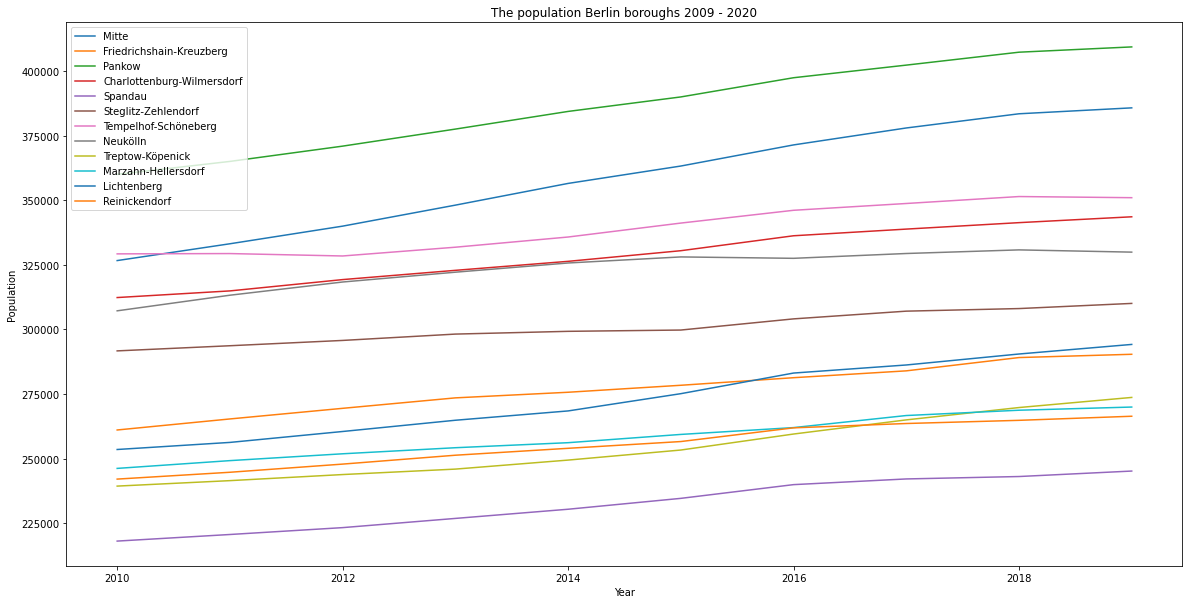

In [7]:
plt.figure(figsize = (20,10))
plt.plot(Berlin_Einwohner['Year'], Berlin_Einwohner[Bezirke])
plt.title('The population Berlin boroughs 2009 - 2020')
plt.xlabel('Year')
plt.ylabel('Population')
plt.legend(Berlin)
plt.show()

### City, Borough, Neighborhood Coordinates

Let's get latitude & longitude coordinates of the center of Berlin and the center of each borough of Berlin using the **Nominatim API** and store them into a Pandas DataFrame. 

In [8]:
geolocator = Nominatim(user_agent="ny_explorer")
Coordinates = []
for i in range(0,len(Berlin)):
                 location = geolocator.geocode(Berlin[i]+', Berlin')
                 latitude = location.latitude
                 longitude = location.longitude
                 Coordinates.append({'Borough':Berlin[i], 'Latitude':latitude, 'Longitude':longitude})
Coordinates = pd.DataFrame(Coordinates)
Coordinates

,Borough,Latitude,Longitude
0,Mitte,52.517885,13.404060
1,Friedrichshain-Kreuzberg,52.501115,13.444285
2,Pankow,52.597917,13.435316
3,Charlottenburg-Wilmersdorf,52.507856,13.263952
4,Spandau,52.535788,13.197792
5,Steglitz-Zehlendorf,52.429205,13.229974
6,Tempelhof-Schöneberg,52.440603,13.373703
7,Neukölln,52.481150,13.435350
8,Treptow-Köpenick,52.417893,13.600185
9,Marzahn-Hellersdorf,52.522523,13.587663


Let's then plot these locations into a map to get an initial impression.

In [9]:
# create map of Toronto using latitude and longitude values
map_berlin = folium.Map(location=Coordinates.iloc[12,[1,2]], zoom_start=11)

# add markers to map
for lat, lng, borough in zip(Coordinates['Latitude'], Coordinates['Longitude'], Coordinates['Borough']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    if borough == 'Berlin':
           c = 'red'
    else:
           c = 'blue'
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=c,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_berlin)  
    
map_berlin

The middle red circle is the center of Berlin. It is the crosspoint of **Friedrichstraße** and **Unter den Linden**.

This amplifies our data:

In [10]:
df = df.join(Coordinates.drop(index=12).set_index('Borough'), on='Borough', how='right')
df 

,Borough,Neighborhood,Area,Population,Density,Latitude,Longitude
0,Mitte,"Mitte, Moabit, Hansaviertel, Tiergarten, Weddi...",3947.0,385.748,9.773,52.517885,13.404060
1,Friedrichshain-Kreuzberg,"Friedrichshain, Kreuzberg",2016.0,290.386,14.404,52.501115,13.444285
2,Pankow,"Prenzlauer Berg, Weißensee, Blankenburg, Heine...",10301.0,409.335,3.974,52.597917,13.435316
3,Charlottenburg-Wilmersdorf,"Charlottenburg, Wilmersdorf, Schmargendorf, Gr...",6472.0,343.592,5.309,52.507856,13.263952
4,Spandau,"Spandau, Haselhorst, Siemensstadt, Staaken, Ga...",9191.0,245.197,2.668,52.535788,13.197792
5,Steglitz-Zehlendorf,"Steglitz, Lichterfelde, Lankwitz, Zehlendorf, ...",10250.0,310.071,3.025,52.429205,13.229974
6,Tempelhof-Schöneberg,"Schöneberg, Friedenau, Tempelhof, Mariendorf, ...",5309.0,350.984,6.611,52.440603,13.373703
7,Neukölln,"Neukölln, Britz, Buckow, Rudow, Gropiusstadt",4493.0,329.917,7.343,52.481150,13.435350
8,Treptow-Köpenick,"Alt-Treptow, Plänterwald, Baumschulenweg, Joha...",16842.0,273.689,1.625,52.417893,13.600185
9,Marzahn-Hellersdorf,"Marzahn, Biesdorf, Kaulsdorf, Mahlsdorf, Helle...",6174.0,269.967,4.373,52.522523,13.587663


Now, let's get the coordinates for the neighborhoods. We will only look into the neighborhoods which we are interested in, namely those whose boroughs have an above average rent.

In [11]:
Mitte = list(map(str.strip,df.loc[0,'Neighborhood'].split(',')))
Friedrichshain_Kreuzberg = list(map(str.strip,df.loc[1,'Neighborhood'].split(',')))
Charlottenburg_Wilmersdorf = list(map(str.strip,df.loc[3,'Neighborhood'].split(',')))

In [56]:
Data = []
for x in Mitte+Friedrichshain_Kreuzberg+Charlottenburg_Wilmersdorf:
    if x in Mitte:
        address = x + ', Mitte, Berlin, Germany'
        geolocator = Nominatim(user_agent="ny_explorer")
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
        Data.append({'Borough':'Mitte', 'Neighborhood':x, 'Latitude':latitude, 'Longitude':longitude})
    elif x in Friedrichshain_Kreuzberg:
        address = x + ', Berlin, Germany'
        geolocator = Nominatim(user_agent="ny_explorer")
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
        Data.append({'Borough':'Friedrichshain_Kreuzberg', 'Neighborhood':x, 'Latitude':latitude, 'Longitude':longitude}) 
    else:
        address = x + ', Berlin, Germany'
        geolocator = Nominatim(user_agent="ny_explorer")
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
        Data.append({'Borough':'Charlottenburg_Wilmersdorf', 'Neighborhood':x, 'Latitude':latitude, 'Longitude':longitude}) 

Berlin_Ortsteil = pd.DataFrame(Data)
Berlin_Ortsteil        

,Borough,Neighborhood,Latitude,Longitude
0,Mitte,Mitte,52.517885,13.404060
1,Mitte,Moabit,52.530102,13.342542
2,Mitte,Hansaviertel,52.519123,13.341872
3,Mitte,Tiergarten,52.509778,13.357260
4,Mitte,Wedding,52.550123,13.341970
5,Mitte,Gesundbrunnen,52.550920,13.384846
6,Friedrichshain_Kreuzberg,Friedrichshain,52.512215,13.450290
7,Friedrichshain_Kreuzberg,Kreuzberg,52.497644,13.411914
8,Charlottenburg_Wilmersdorf,Charlottenburg,52.515747,13.309683
9,Charlottenburg_Wilmersdorf,Wilmersdorf,52.487115,13.320330


Again, we will plot the neighborhoods into a map to get some impression.

In [13]:
map_berlin = folium.Map(location=Coordinates.iloc[12,[1,2]], zoom_start=12)

# add markers to map
for lat, lng, ortsteil in zip(Berlin_Ortsteil['Latitude'], Berlin_Ortsteil['Longitude'], Berlin_Ortsteil['Neighborhood']):
    label = '{}'.format(ortsteil)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_berlin)  
    
map_berlin

### Foursquare
Now that we have our location candidates, let's use Foursquare API to get info on the venus in each neighborhood. In particular, we are interested in the nearby hotels.

Foursquare credentials are defined in hidden cell bellow.

In [14]:
CLIENT_ID = '1DPGMGDNDTEIRPC4BNO30MK5BFIQ5LLE4TEOK0EJHSUFNPHG' # your Foursquare ID
CLIENT_SECRET = '5MZHZLG15KWWO5NNE4XXFVFNXW51KWH1UK0UNKQ4MLKYRZGN' # your Foursquare Secret

In [15]:
VERSION = '20210519' # Foursquare API version

LIMIT = 10000 # limit of number of venues returned by Foursquare API

radius = 1000 # define radius

In [16]:
# Category IDs corresponding to hotels were taken from Foursquare web site (https://developer.foursquare.com/docs/resources/categories):

hotel_category = '4bf58dd8d48988d1fa931735' # 'Root' category for all hotel-related venues

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
#         print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [18]:
nearby_venues = getNearbyVenues(names=Berlin_Ortsteil['Neighborhood'],
                                   latitudes=Berlin_Ortsteil['Latitude'],
                                   longitudes=Berlin_Ortsteil['Longitude']
                                  )

In [19]:
nearby_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Mitte,52.517885,13.40406,"Bronzestatue ""Heiliger St. Georg im Kampf mit ...",52.516290,13.405558,Outdoor Sculpture
1,Mitte,52.517885,13.40406,Designpanoptikum - surreales Museum für indust...,52.516941,13.406072,Museum
2,Mitte,52.517885,13.40406,Kuppelumgang Berliner Dom,52.518966,13.400981,Scenic Lookout
3,Mitte,52.517885,13.40406,Lustgarten,52.518469,13.399454,Garden
4,Mitte,52.517885,13.40406,Tigertörtchen,52.517150,13.407926,Cupcake Shop


In [20]:
nearby_venues.shape

(1158, 7)

In [21]:
nearby_venues['Neighborhood'].value_counts()

Friedrichshain         100
Moabit                 100
Kreuzberg              100
Tiergarten             100
Mitte                  100
Charlottenburg         100
Halensee               100
Hansaviertel           100
Wilmersdorf             92
Gesundbrunnen           89
Wedding                 54
Schmargendorf           39
Westend                 36
Grunewald               29
Charlottenburg-Nord     19
Name: Neighborhood, dtype: int64

This concludes the data gathering phase - we're now ready to use this data for analysis to produce the report!

## Methodology <a name="methodology"></a>

The goal of this project is to find out the neighborhoods and areas of Berlin that would have the highest rent in the next a few years. Therefore, two factors are extremely import. One is the current average rent, the other is the expected growth of the rent. From the preliminary look on the data that we have collected, it is clear that currently Berlin-Mitte has the highest average rent - 13.70 EUR every square meter, Berlin-Friedrichshain-Kreuzberg comes with 13.11 EUR the second, and Berlin-Charlottenburg-Wilmersdorf with 12.38 EUR is also above average. Then we will come to the growth. It is quite clear from the line chart that none of the boroughs of Berlin whose average rents are below the Berlin-average could have a chance to climbe up to the top. Thus it is reasonable for us to only focus on these three above mentioned boroughs.

In first step we will use **simple linear regression models** to estimate the growth of the average rent of each of the three boroughs and Berlin as a whole from 2009 to 2020. We visualize the results and put them together to compare. 

The second step of our analysis will be to use **simple linear regression models** to estimate the growth of the population of each of the three boroughs and Berlin as a whole from 2009 to 2020. We also visualize the results and compare them. 

In third step we will create **clusters of locations based on the patterns their nearby venues** (**k-means clustering** and **density-based clustering**) for all the neighborhoods in the three boroughs having in mind that areas with similar patterns of nearby venues should have similar average rent. We will analyse the similarities among each cluster.

In the fourth step we will use the patterns that we discovered to estimite which areas of Berlin should have the highest rent in the next a few years.

In the last step we will use the data collected from [Berlin Mietspiegel](https://www.stadtentwicklung.berlin.de/wohnen/mietspiegel/) to test our estimation.

## Analysis <a name="analysis"></a>

In this simple linear regression model we use the years as independent variable to estimate the dependent variables - the average rent of each borough.

In [28]:
x = np.asanyarray(Berlin_Mieten[['Year']])
y_B = np.asanyarray(Berlin_Mieten[['Berlin']])
y_M = np.asanyarray(Berlin_Mieten[['Mitte']])
y_FK = np.asanyarray(Berlin_Mieten[['Friedrichshain-Kreuzberg']])
y_CW = np.asanyarray(Berlin_Mieten[['Charlottenburg-Wilmersdorf']])
regr_Berlin = linear_model.LinearRegression().fit (x, y_B)
regr_M = linear_model.LinearRegression().fit (x, y_M)
regr_FK = linear_model.LinearRegression().fit (x, y_FK)
regr_CW = linear_model.LinearRegression().fit (x, y_CW)

# The coefficients
print ('Berlin-Coefficients: ', regr_Berlin.coef_)
print ('Berlin-Mitte-Coefficients: ', regr_M.coef_)
print ('Berlin-Friedrichshain-Kreuzberg-Coefficients: ', regr_FK.coef_)
print ('Berlin-Charlottenburg-Wilmersdorf-Coefficients: ', regr_CW.coef_)

Berlin-Coefficients:  [[0.44519635]]
Berlin-Mitte-Coefficients:  [[0.77734222]]
Berlin-Friedrichshain-Kreuzberg-Coefficients:  [[0.65827489]]
Berlin-Charlottenburg-Wilmersdorf-Coefficients:  [[0.5398317]]


Here the coefficients indicate the rate of growth - the higher the number is, the faster it growth.

Let's visualize the result.

Text(0, 0.5, 'Berlin-Charlottenburg-Wilmersdorf Rent')

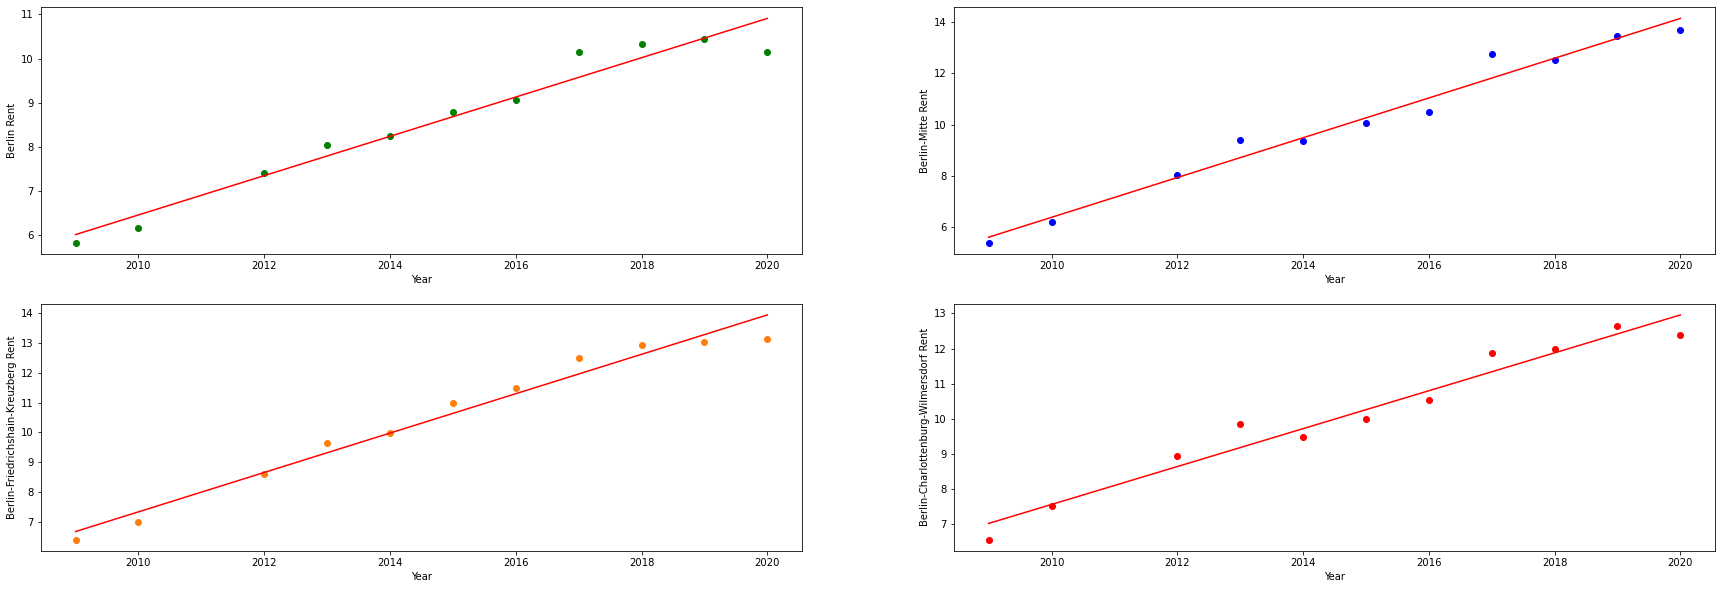

In [29]:
Mietpreisentwicklung = plt.subplots(nrows=2, ncols=2, figsize = (30,10))
fig, ((ax1,ax2),(ax3,ax4)) = Mietpreisentwicklung
ax1.scatter(Berlin_Mieten.Year, Berlin_Mieten.Berlin,  color='green')
ax1.plot(x, regr_Berlin.coef_[0][0]*x + regr_Berlin.intercept_[0], '-r')
ax1.set_xlabel("Year")
ax1.set_ylabel("Berlin Rent")

ax2.scatter(Berlin_Mieten.Year, Berlin_Mieten.Mitte,  color='blue')
ax2.plot(x, regr_M.coef_[0][0]*x + regr_M.intercept_[0], '-r')
ax2.set_xlabel("Year")
ax2.set_ylabel("Berlin-Mitte Rent")

ax3.scatter(Berlin_Mieten.Year, Berlin_Mieten['Friedrichshain-Kreuzberg'],  color='tab:orange')
ax3.plot(x, regr_FK.coef_[0][0]*x + regr_FK.intercept_[0], '-r')
ax3.set_xlabel("Year")
ax3.set_ylabel("Berlin-Friedrichshain-Kreuzberg Rent")

ax4.scatter(Berlin_Mieten.Year, Berlin_Mieten['Charlottenburg-Wilmersdorf'],  color='red')
ax4.plot(x, regr_CW.coef_[0][0]*x + regr_CW.intercept_[0], '-r')
ax4.set_xlabel("Year")
ax4.set_ylabel("Berlin-Charlottenburg-Wilmersdorf Rent")

The models fit the samples quite well and no sign of overfitting. However, since the values only differ marginally, it is hard to compare them visually, even side by side! 

So, let's put them together!

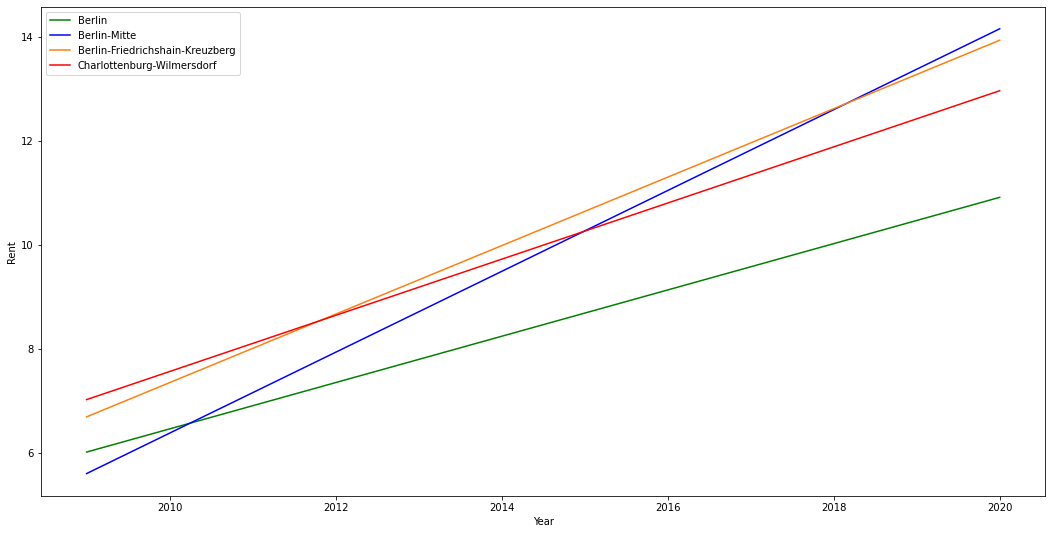

In [30]:
plt.figure(figsize = (18,9))
plt.plot(x, regr_Berlin.coef_[0][0]*x + regr_Berlin.intercept_[0], '-g', label='Berlin')
plt.plot(x, regr_M.coef_[0][0]*x + regr_M.intercept_[0], '-b', label='Berlin-Mitte')
plt.plot(x, regr_FK.coef_[0][0]*x + regr_FK.intercept_[0], 'tab:orange', label='Berlin-Friedrichshain-Kreuzberg')
plt.plot(x, regr_CW.coef_[0][0]*x + regr_CW.intercept_[0], '-r', label='Charlottenburg-Wilmersdorf')
plt.xlabel("Year")
plt.ylabel("Rent")
plt.legend()
plt.show()

Clearly, Berlin-Mitte has not only the highest rent, but also the fastest rent growth! Berlin-Friedrichshain-Kreuzberg in the second place with respect to both current rent and rent growth.

Next, we move to population growth.

In [31]:
x = np.asanyarray(Berlin_Einwohner[['Year']])
y_M = np.asanyarray(Berlin_Einwohner[['Mitte']])
y_FK = np.asanyarray(Berlin_Einwohner[['Friedrichshain-Kreuzberg']])
y_CW = np.asanyarray(Berlin_Einwohner[['Charlottenburg-Wilmersdorf']])
regr_M = linear_model.LinearRegression().fit (x, y_M)
regr_FK = linear_model.LinearRegression().fit (x, y_FK)
regr_CW = linear_model.LinearRegression().fit (x, y_CW)

# The coefficients
print ('Berlin-Mitte-Coefficients: ', regr_M.coef_[0][0])
print ('Berlin-Friedrichshain-Kreuzberg-Coefficients: ',regr_FK.coef_[0][0])
print ('Berlin-Charlottenburg-Wilmersdorf-Coefficients: ', regr_CW.coef_[0][0])

Berlin-Mitte-Coefficients:  6973.436363636361
Berlin-Friedrichshain-Kreuzberg-Coefficients:  3203.7090909090903
Berlin-Charlottenburg-Wilmersdorf-Coefficients:  3685.70303030303


Clearly, Berlin-Mitte has the fastest population growth, and Berlin-Charlottenburg-Wilmersdorf is the second. But here one has to pay attention that population growth is not equal to population density growth, and the latter reflex more about the rent growth. Let's also consider the population density growth by dividing the current data by the areas.

In [32]:
x = np.asanyarray(Berlin_Einwohner[['Year']])
y_M = np.asanyarray(Berlin_Einwohner[['Mitte']]/3947.0)
y_FK = np.asanyarray(Berlin_Einwohner[['Friedrichshain-Kreuzberg']]/2016.0)
y_CW = np.asanyarray(Berlin_Einwohner[['Charlottenburg-Wilmersdorf']]/6472.0)
regr_M2 = linear_model.LinearRegression().fit (x, y_M)
regr_FK2 = linear_model.LinearRegression().fit (x, y_FK)
regr_CW2 = linear_model.LinearRegression().fit (x, y_CW)

# The coefficients
print ('Berlin-Mitte-Coefficients: ', regr_M2.coef_[0][0])
print ('Berlin-Friedrichshain-Kreuzberg-Coefficients: ',regr_FK2.coef_[0][0])
print ('Berlin-Charlottenburg-Wilmersdorf-Coefficients: ', regr_CW2.coef_[0][0])

Berlin-Mitte-Coefficients:  1.7667687772070833
Berlin-Friedrichshain-Kreuzberg-Coefficients:  1.5891414141414126
Berlin-Charlottenburg-Wilmersdorf-Coefficients:  0.5694843989961417


Now our ranking comes back. It is consistent with the ranking of rent growth.

Next, let's visualize the population growth.

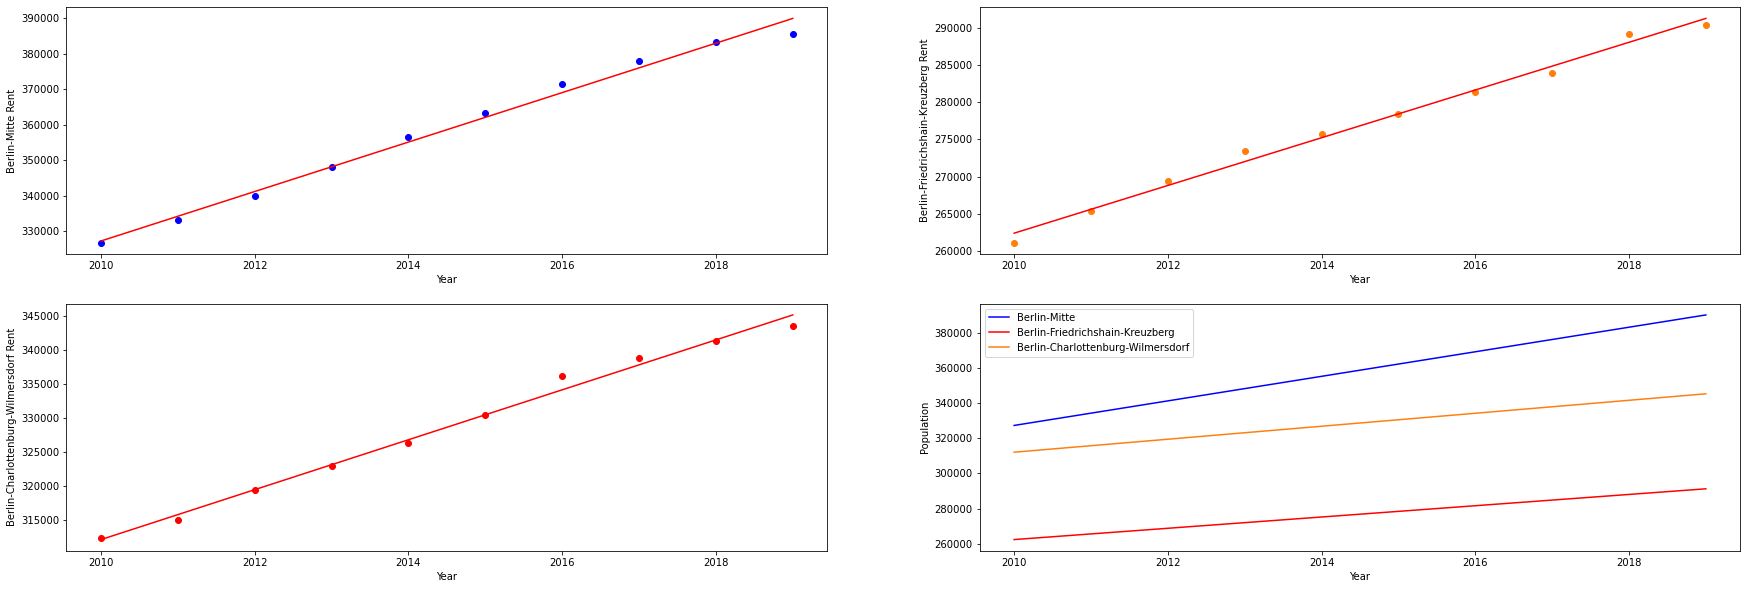

In [33]:
Bevölkerungsentwicklung = plt.subplots(nrows=2, ncols=2, figsize = (30,10))
fig, ((ax1,ax2),(ax3,ax4)) = Bevölkerungsentwicklung 

ax1.scatter(Berlin_Einwohner.Year, Berlin_Einwohner.Mitte,  color='blue')
ax1.plot(x, regr_M.coef_[0][0]*x + regr_M.intercept_[0], '-r')
ax1.set_xlabel("Year")
ax1.set_ylabel("Berlin-Mitte Rent")

ax2.scatter(Berlin_Einwohner.Year, Berlin_Einwohner['Friedrichshain-Kreuzberg'],  color='tab:orange')
ax2.plot(x, regr_FK.coef_[0][0]*x + regr_FK.intercept_[0], '-r')
ax2.set_xlabel("Year")
ax2.set_ylabel("Berlin-Friedrichshain-Kreuzberg Rent")

ax3.scatter(Berlin_Einwohner.Year, Berlin_Einwohner['Charlottenburg-Wilmersdorf'],  color='red')
ax3.plot(x, regr_CW.coef_[0][0]*x + regr_CW.intercept_[0], '-r')
ax3.set_xlabel("Year")
ax3.set_ylabel("Berlin-Charlottenburg-Wilmersdorf Rent")

ax4.plot(x, regr_M.coef_[0][0]*x + regr_M.intercept_[0], '-b', label='Berlin-Mitte')
ax4.plot(x, regr_FK.coef_[0][0]*x + regr_FK.intercept_[0], '-r', label='Berlin-Friedrichshain-Kreuzberg')
ax4.plot(x, regr_CW.coef_[0][0]*x + regr_CW.intercept_[0], 'tab:orange', label='Berlin-Charlottenburg-Wilmersdorf')
ax4.set_xlabel("Year")
ax4.set_ylabel("Population")
ax4.legend()

Now let's use **density-based clustering DBSCAN** to cluster the nearby venues. This clustering is only based on the locations of the venues, not base on the types of the venues. The advantage of DBSCAN is that it is robust against the outliers and you don't have to specify the number *k* which is an important parameter in the k-means clustering.

In [34]:
Clus_dataSet = nearby_venues[['Venue Latitude','Venue Longitude']]
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

# Compute DBSCAN
db = DBSCAN(eps=0.2, min_samples=10).fit(Clus_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
nearby_venues["Clus_Db"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 


# A sample of clusters
nearby_venues.head(5)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Clus_Db
0,Mitte,52.517885,13.40406,"Bronzestatue ""Heiliger St. Georg im Kampf mit ...",52.516290,13.405558,Outdoor Sculpture,0
1,Mitte,52.517885,13.40406,Designpanoptikum - surreales Museum für indust...,52.516941,13.406072,Museum,0
2,Mitte,52.517885,13.40406,Kuppelumgang Berliner Dom,52.518966,13.400981,Scenic Lookout,0
3,Mitte,52.517885,13.40406,Lustgarten,52.518469,13.399454,Garden,0
4,Mitte,52.517885,13.40406,Tigertörtchen,52.517150,13.407926,Cupcake Shop,0


Here are the labels. The venues with label "-1" are the outliers.

In [35]:
set(labels)

{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

In [42]:
print('The outliers are in: ', end='\n')
for x in nearby_venues[nearby_venues['Clus_Db']==-1].Neighborhood.unique():
    print(x)

The outliers are in: 
Wedding
Grunewald
Westend
Charlottenburg-Nord


Let's now visualize the clusters on the maps.

In [47]:
map_berlin = folium.Map(location=Coordinates.iloc[12,[1,2]], zoom_start=12)

print('The clusters and the coordinates of their centroids are: ', end='\n')

# Visualization1
for clust_number in set(labels):
    clust_set = nearby_venues[nearby_venues.Clus_Db == clust_number] 
    
# Set color for the nodes
    x = np.arange(len(set(labels)))
    ys = [i + x + (i*x)**2 for i in range(len(set(labels)))]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]
    if clust_number != -1:
        cenx=np.mean(clust_set['Venue Latitude']) 
        ceny=np.mean(clust_set['Venue Longitude']) 
        print ("Cluster "+str(clust_number)+', ', end='')
        for i in range(0,len(clust_set.Neighborhood.unique())):
                    print(clust_set.Neighborhood.unique()[i], end=', ')
        print('coordinates: '+ str(cenx) + ', ' + str(ceny)+'.', end='\n')
                  
                    
                    
                
        for x,y in zip(clust_set['Venue Latitude'], clust_set['Venue Longitude']):
                     label = '{}, Cluster {}'.format(clust_set.Neighborhood.unique()[0], clust_number)
                     label = folium.Popup(label, parse_html=True)
                     folium.CircleMarker(
                         [x, y],
                         radius=3,
                         popup=label,
                         color=rainbow[clust_number-1],
                         fill=True,
                         fill_color='#cc3131',
                         fill_opacity=1.7,
                         parse_html=False).add_to(map_berlin)  
                    
        label = '{}, Cluster {}'.format(clust_set.Neighborhood.unique()[0], clust_number)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
                [cenx, ceny],
                radius=3,
                popup=label,
                color='black',
                fill=True,
                fill_color='#cc3131',
                fill_opacity=1.7,
                parse_html=False).add_to(map_berlin) 
        
map_berlin

The clusters and the coordinates of their centroids are: 
Cluster 0, Mitte, coordinates: 52.52022415596093, 13.40376360485069.
Cluster 1, Moabit, Hansaviertel, Tiergarten, Charlottenburg, coordinates: 52.518623016714244, 13.346298453115716.
Cluster 2, Wedding, coordinates: 52.550859692238696, 13.34703394135773.
Cluster 3, Gesundbrunnen, coordinates: 52.5510893118954, 13.38367863317755.
Cluster 4, Friedrichshain, coordinates: 52.51134647226065, 13.453956962818445.
Cluster 5, Kreuzberg, coordinates: 52.498081090739845, 13.416578550386202.
Cluster 6, Charlottenburg, Wilmersdorf, Schmargendorf, Halensee, coordinates: 52.49938978137405, 13.30797501447628.
Cluster 7, Schmargendorf, coordinates: 52.47704837470861, 13.288504919307186.
Cluster 8, Grunewald, coordinates: 52.48626693865566, 13.26500499406306.
Cluster 9, Westend, coordinates: 52.513962596889506, 13.261165276263194.
Cluster 10, Charlottenburg-Nord, coordinates: 52.53696879712252, 13.291191953438398.


The result is no supprising. Since the clustering is based on the locations of the venues, the centroids of the clusters are basically the centroids of the neighborhoods, with expections cluster 1 and cluster 6 where large neighborhoods are clustered together. But we can still read some information out of this clustering: cluster 7,8,9,10 have very few venues in them. In Berlin, this means simply that these are forests. Living in forests can also be expensive, but you would not expect that the rent rises sharply there, because forest stays as forest unless there is a forest fire. Also, neighborhoods with outliers, *i.e.* those who get '-1' in their labels, do not look promising, because in crowded areas, the venues are usually clustered together.

Now let's cluster the venues based on their types. First of all, we should transfer the string values to numeric values in oder to perform analysis.

In [53]:
# one hot encoding
hotspots = pd.get_dummies(nearby_venues[['Venue Category']], prefix="", prefix_sep="")
print(hotspots.columns.get_loc("Neighborhood"))

# add neighborhood column back to dataframe
hotspots['Neighborhoods'] = nearby_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [hotspots.columns[-1]] + list(hotspots.columns[:-1])
hotspots = hotspots[fixed_columns]

hotspots.head(10)

145


,Neighborhoods,Accessories Store,Adult Boutique,African Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Vacation Rental,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Yemeni Restaurant,Yoga Studio,Zoo Exhibit
0,Mitte,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Mitte,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Mitte,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Mitte,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Mitte,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Mitte,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Mitte,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Mitte,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,Mitte,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,Mitte,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we take the mean of the values according to each neighborhood to see which kind of venue is more popular in the neighborhood.

In [54]:
grouped_hotspots = hotspots.groupby('Neighborhoods').mean().reset_index()
grouped_hotspots

,Neighborhoods,Accessories Store,Adult Boutique,African Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Vacation Rental,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Yemeni Restaurant,Yoga Studio,Zoo Exhibit
0,Charlottenburg,0.00000,0.00,0.000000,0.00000,0.000000,0.010000,0.00,0.020000,0.000000,...,0.01,0.00000,0.020000,0.00,0.000000,0.01,0.010000,0.000000,0.00,0.00
1,Charlottenburg-Nord,0.00000,0.00,0.000000,0.00000,0.000000,0.000000,0.00,0.000000,0.000000,...,0.00,0.00000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.00
2,Friedrichshain,0.00000,0.00,0.000000,0.00000,0.010000,0.000000,0.00,0.000000,0.000000,...,0.00,0.03000,0.010000,0.00,0.000000,0.00,0.010000,0.000000,0.00,0.00
3,Gesundbrunnen,0.00000,0.00,0.000000,0.00000,0.011236,0.000000,0.00,0.011236,0.000000,...,0.00,0.00000,0.000000,0.00,0.011236,0.00,0.011236,0.000000,0.00,0.00
4,Grunewald,0.00000,0.00,0.000000,0.00000,0.000000,0.000000,0.00,0.000000,0.034483,...,0.00,0.00000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.00
5,Halensee,0.00000,0.00,0.000000,0.00000,0.000000,0.000000,0.00,0.020000,0.000000,...,0.00,0.01000,0.010000,0.00,0.000000,0.00,0.010000,0.000000,0.00,0.00
6,Hansaviertel,0.00000,0.00,0.000000,0.00000,0.000000,0.020000,0.01,0.010000,0.000000,...,0.00,0.00000,0.030000,0.02,0.000000,0.00,0.000000,0.000000,0.00,0.00
7,Kreuzberg,0.00000,0.00,0.010000,0.00000,0.030000,0.000000,0.01,0.000000,0.000000,...,0.00,0.01000,0.000000,0.02,0.000000,0.03,0.010000,0.000000,0.02,0.00
8,Mitte,0.00000,0.01,0.000000,0.00000,0.050000,0.020000,0.00,0.000000,0.000000,...,0.00,0.00000,0.010000,0.00,0.000000,0.00,0.010000,0.000000,0.00,0.00
9,Moabit,0.00000,0.00,0.000000,0.00000,0.010000,0.000000,0.00,0.010000,0.000000,...,0.00,0.02000,0.030000,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.00


In [57]:
# set number of clusters
kclusters = 7

grouped_clustering = grouped_hotspots.drop('Neighborhoods', axis=1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(grouped_clustering)

labels = kmeans.labels_
grouped_hotspots["Cluster Labels"]=labels

# check cluster labels generated for each row in the dataframe
Berlin_Ortsteil = Berlin_Ortsteil.join(grouped_hotspots[['Neighborhoods','Cluster Labels']].set_index('Neighborhoods'), on='Neighborhood')
Berlin_Ortsteil

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels
0,Mitte,Mitte,52.517885,13.404060,2
1,Mitte,Moabit,52.530102,13.342542,4
2,Mitte,Hansaviertel,52.519123,13.341872,4
3,Mitte,Tiergarten,52.509778,13.357260,2
4,Mitte,Wedding,52.550123,13.341970,0
5,Mitte,Gesundbrunnen,52.550920,13.384846,4
6,Friedrichshain_Kreuzberg,Friedrichshain,52.512215,13.450290,3
7,Friedrichshain_Kreuzberg,Kreuzberg,52.497644,13.411914,3
8,Charlottenburg_Wilmersdorf,Charlottenburg,52.515747,13.309683,0
9,Charlottenburg_Wilmersdorf,Wilmersdorf,52.487115,13.320330,4


Now we see that Berlin-Mitte-Mitte and Berlin-Mitte-Tiergarten are in the same cluster - cluster 2, Berlin-Friedrichshain and Berlin-Kreuzberg are in the same cluster 3. Based on what we have observed so far, there are good reasons to believe that cluster 2 is the top-tier, followed by cluster 3, and cluster 4 seems to be also competitive. Let's visualize the result.

In [58]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Berlin_Ortsteil['Latitude'], Berlin_Ortsteil['Longitude'], Berlin_Ortsteil['Neighborhood'], Berlin_Ortsteil['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Let's look into the pattern of the venues in each cluster.

In [59]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [60]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhoods']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhoods'] = grouped_hotspots['Neighborhoods']

for ind in np.arange(grouped_hotspots.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped_hotspots.drop("Cluster Labels",axis=1).iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Charlottenburg,Café,Italian Restaurant,Chinese Restaurant,Gym / Fitness Center,Supermarket,Sushi Restaurant,German Restaurant,Pizza Place,Asian Restaurant,Doner Restaurant
1,Charlottenburg-Nord,Intersection,Metro Station,Bus Stop,Supermarket,Post Office,Plaza,Pizza Place,Rock Climbing Spot,Persian Restaurant,Shipping Store
2,Friedrichshain,Café,Coffee Shop,Ice Cream Shop,Falafel Restaurant,Nightclub,Vegetarian / Vegan Restaurant,Pizza Place,Middle Eastern Restaurant,Bagel Shop,Bookstore
3,Gesundbrunnen,Bar,Café,Coffee Shop,Turkish Restaurant,Bakery,Drugstore,Trail,Bookstore,Garden,Supermarket
4,Grunewald,Lake,German Restaurant,Café,Italian Restaurant,Hotel,Supermarket,Plaza,Soccer Field,Sports Club,Park
5,Halensee,Italian Restaurant,Hotel,Café,Supermarket,Trattoria/Osteria,Plaza,Bar,Gym / Fitness Center,Bakery,Ice Cream Shop
6,Hansaviertel,Hotel,Café,Italian Restaurant,Burger Joint,Doner Restaurant,Vietnamese Restaurant,Restaurant,Park,German Restaurant,Beer Garden
7,Kreuzberg,Coffee Shop,Café,Bar,German Restaurant,Ice Cream Shop,Wine Bar,Art Gallery,Dance Studio,Music Store,Gourmet Shop
8,Mitte,Hotel,Coffee Shop,Art Gallery,Plaza,History Museum,Exhibit,Clothing Store,Café,German Restaurant,Museum
9,Moabit,Café,Bar,Burger Joint,Turkish Restaurant,Doner Restaurant,Italian Restaurant,Restaurant,Cocktail Bar,Breakfast Spot,Hotel


We see that in cluster 2, hotel is the most popular venue type and there is the museum venue type, especially in Berlin-Mitte-Mitte. This tells us that these two places lie at the heart of the city's tourist attractions. Thus very high average rent is expected in each of these neighborhoods. We also see that Berlin-Mitte-Hansaviertel and Berlin-Wilmersdorf from cluster 4 have hotel as their most popular venues, although there are no museums.

It seems that the density of hotels is a good indictor of the average rent of an area. Let's look into that.

In [62]:
def getHotels(names, latitudes, longitudes, category=hotel_category, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
#         print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            category,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_hotels = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_hotels.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Hotel', 
                  'Hotel Latitude', 
                  'Hotel Longitude',
                  'Category']
    
    return(nearby_hotels)

In [63]:
nearby_hotels = getHotels(names=Berlin_Ortsteil['Neighborhood'],
                                   latitudes=Berlin_Ortsteil['Latitude'],
                                   longitudes=Berlin_Ortsteil['Longitude']
                                  )

In [70]:
print("There are {} hotels nearby.".format(nearby_hotels.shape[0]))

There are 208 hotels nearby.


In [64]:
nearby_hotels.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Hotel,Hotel Latitude,Hotel Longitude,Category
0,Mitte,52.517885,13.40406,Radisson Blu,52.519561,13.402857,Hotel
1,Mitte,52.517885,13.40406,Capri by Fraser Berlin,52.513972,13.404902,Hotel
2,Mitte,52.517885,13.40406,Adina Apartment Hotel Berlin Hackescher Markt,52.522293,13.404273,Hotel
3,Mitte,52.517885,13.40406,Hotel de Rome,52.516025,13.393938,Hotel
4,Mitte,52.517885,13.40406,Motel One Berlin-Hackescher Markt,52.523157,13.408722,Hotel


In [66]:
for nbhd in Berlin_Ortsteil.Neighborhood:
    print('There are {} Hotels in the vicinity of Berlin-{}.'.format(len(nearby_hotels[nearby_hotels['Neighborhood']==nbhd].Hotel),nbhd))

There are 55 Hotels in the vicinity of Berlin-Mitte.
There are 12 Hotels in the vicinity of Berlin-Moabit.
There are 15 Hotels in the vicinity of Berlin-Hansaviertel.
There are 29 Hotels in the vicinity of Berlin-Tiergarten.
There are 2 Hotels in the vicinity of Berlin-Wedding.
There are 10 Hotels in the vicinity of Berlin-Gesundbrunnen.
There are 29 Hotels in the vicinity of Berlin-Friedrichshain.
There are 15 Hotels in the vicinity of Berlin-Kreuzberg.
There are 9 Hotels in the vicinity of Berlin-Charlottenburg.
There are 11 Hotels in the vicinity of Berlin-Wilmersdorf.
There are 2 Hotels in the vicinity of Berlin-Schmargendorf.
There are 2 Hotels in the vicinity of Berlin-Grunewald.
There are 1 Hotels in the vicinity of Berlin-Westend.
There are 0 Hotels in the vicinity of Berlin-Charlottenburg-Nord.
There are 16 Hotels in the vicinity of Berlin-Halensee.


As expected, Berlin-Mitte has the most hotels in its vicinity. Although Berlin-Tiergarten and Berlin-Friedrichshain have the same number of hotels in their vicinities, considering the small size of Berlin-Tiergarten, hotels are obviously denser in Tiergarten than in Friedrichshain. 

Let's visualize these observations.

In [72]:
map_berlin = folium.Map(location=Coordinates.iloc[12,[1,2]], zoom_start=12)

# add markers to map
for lat, lng, ortsteil in zip(nearby_hotels['Hotel Latitude'], nearby_hotels['Hotel Longitude'], nearby_hotels['Neighborhood']):
    label = '{}'.format(ortsteil)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='black',
        fill_opacity=0.7,
        parse_html=False).add_to(map_berlin)  
    
map_berlin

Let's use DBSCAN again to cluster the hotels based on their locations.

In [74]:
Clus_dataSet = nearby_hotels[['Hotel Latitude','Hotel Longitude']]
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

# Compute DBSCAN
db = DBSCAN(eps=0.2, min_samples=10).fit(Clus_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
nearby_hotels["Clus_Db"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 


# A sample of clusters
nearby_hotels.head(5)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Hotel,Hotel Latitude,Hotel Longitude,Category,Clus_Db
0,Mitte,52.517885,13.40406,Radisson Blu,52.519561,13.402857,Hotel,1
1,Mitte,52.517885,13.40406,Capri by Fraser Berlin,52.513972,13.404902,Hotel,0
2,Mitte,52.517885,13.40406,Adina Apartment Hotel Berlin Hackescher Markt,52.522293,13.404273,Hotel,1
3,Mitte,52.517885,13.40406,Hotel de Rome,52.516025,13.393938,Hotel,0
4,Mitte,52.517885,13.40406,Motel One Berlin-Hackescher Markt,52.523157,13.408722,Hotel,1


In [79]:
set(labels)

{-1, 0, 1, 2, 3, 4}

In [78]:
map_berlin = folium.Map(location=Coordinates.iloc[12,[1,2]], zoom_start=12)

print('The clusters and the coordinates of their centroids are: ', end='\n')

# Visualization1
for clust_number in set(labels):
    clust_set = nearby_hotels[nearby_hotels.Clus_Db == clust_number] 
    
# Set color for the nodes
    x = np.arange(len(set(labels)))
    ys = [i + x + (i*x)**2 for i in range(len(set(labels)))]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]
    if clust_number != -1:
        cenx=np.mean(clust_set['Hotel Latitude']) 
        ceny=np.mean(clust_set['Hotel Longitude']) 
        print ("Cluster "+str(clust_number)+', ', end='')
        for i in range(0,len(clust_set.Neighborhood.unique())):
                    print(clust_set.Neighborhood.unique()[i], end=', ')
        print('coordinates: '+ str(cenx) + ', ' + str(ceny)+'.', end='\n')
                  
                    
                    
                
        for x,y in zip(clust_set['Hotel Latitude'], clust_set['Hotel Longitude']):
                     label = '{}, Cluster {}'.format(clust_set.Neighborhood.unique()[0], clust_number)
                     label = folium.Popup(label, parse_html=True)
                     folium.CircleMarker(
                         [x, y],
                         radius=3,
                         popup=label,
                         color=rainbow[clust_number-1],
                         fill=True,
                         fill_color='#cc3131',
                         fill_opacity=1.7,
                         parse_html=False).add_to(map_berlin)  
                    
        label = '{}, Cluster {}'.format(clust_set.Neighborhood.unique()[0], clust_number)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
                [cenx, ceny],
                radius=3,
                popup=label,
                color='black',
                fill=True,
                fill_color='#cc3131',
                fill_opacity=1.7,
                parse_html=False).add_to(map_berlin) 
        
map_berlin

The clusters and the coordinates of their centroids are: 
Cluster 0, Mitte, coordinates: 52.51311007061527, 13.400613842047896.
Cluster 1, Mitte, coordinates: 52.52292197640304, 13.404153473698498.
Cluster 2, Moabit, Hansaviertel, coordinates: 52.525921857800796, 13.34378139897381.
Cluster 3, Tiergarten, coordinates: 52.505297478714574, 13.35403627597626.
Cluster 4, Friedrichshain, coordinates: 52.51138271709561, 13.452391736530407.


Let's create a map showing **heatmap / density of restaurants** and try to extract some meaningfull info from that. Also, let's show **borders of Berlin boroughs** on our map and a few circles indicating distance of 1km, 2km and 3km from Alexanderplatz.

In [38]:
berlin_boroughs_url = 'https://raw.githubusercontent.com/m-hoerz/berlin-shapes/master/berliner-bezirke.geojson'
berlin_boroughs = requests.get(berlin_boroughs_url).json()

def boroughs_style(feature):
    return { 'color': 'blue', 'fill': False }

In [39]:
restaurant_latlons = [[res[2], res[3]] for res in restaurants.values()]

italian_latlons = [[res[2], res[3]] for res in italian_restaurants.values()]

NameError: name 'restaurants' is not defined

In [144]:
# from folium import plugins
# from folium.plugins import HeatMap

# map_berlin = folium.Map(location=berlin_center, zoom_start=13)
# folium.TileLayer('cartodbpositron').add_to(map_berlin) #cartodbpositron cartodbdark_matter
# HeatMap(restaurant_latlons).add_to(map_berlin)
# folium.Marker(berlin_center).add_to(map_berlin)
# folium.Circle(berlin_center, radius=1000, fill=False, color='white').add_to(map_berlin)
# folium.Circle(berlin_center, radius=2000, fill=False, color='white').add_to(map_berlin)
# folium.Circle(berlin_center, radius=3000, fill=False, color='white').add_to(map_berlin)
# folium.GeoJson(berlin_boroughs, style_function=boroughs_style, name='geojson').add_to(map_berlin)
# map_berlin

Looks like a few pockets of low restaurant density closest to city center can be found **south, south-east and east from Alexanderplatz**. 

Let's create another heatmap map showing **heatmap/density of Italian restaurants** only.

In [145]:
# map_berlin = folium.Map(location=berlin_center, zoom_start=13)
# folium.TileLayer('cartodbpositron').add_to(map_berlin) #cartodbpositron cartodbdark_matter
# HeatMap(italian_latlons).add_to(map_berlin)
# folium.Marker(berlin_center).add_to(map_berlin)
# folium.Circle(berlin_center, radius=1000, fill=False, color='white').add_to(map_berlin)
# folium.Circle(berlin_center, radius=2000, fill=False, color='white').add_to(map_berlin)
# folium.Circle(berlin_center, radius=3000, fill=False, color='white').add_to(map_berlin)
# folium.GeoJson(berlin_boroughs, style_function=boroughs_style, name='geojson').add_to(map_berlin)
# map_berlin

This map is not so 'hot' (Italian restaurants represent a subset of ~15% of all restaurants in Berlin) but it also indicates higher density of existing Italian restaurants directly north and west from Alexanderplatz, with closest pockets of **low Italian restaurant density positioned east, south-east and south from city center**.

Based on this we will now focus our analysis on areas *south-west, south, south-east and east from Berlin center* - we will move the center of our area of interest and reduce it's size to have a radius of **2.5km**. This places our location candidates mostly in boroughs **Kreuzberg and Friedrichshain** (another potentially interesting borough is **Prenzlauer Berg** with large low restaurant density north-east from city center, however this borough is less interesting to stakeholders as it's mostly residental and less popular with tourists).

### Kreuzberg and Friedrichshain

Analysis of popular travel guides and web sites often mention Kreuzberg and Friedrichshain as beautifull, interesting, rich with culture, 'hip' and 'cool' Berlin neighborhoods popular with tourists and loved by Berliners.

*"Bold and brazen, Kreuzberg's creative people, places, and spaces might challenge your paradigm."* Tags: Nightlife, Artsy, Dining, Trendy, Loved by Berliners, Great Transit (airbnb.com)

*"Kreuzberg has long been revered for its diverse cultural life and as a part of Berlin where alternative lifestyles have flourished. Envisioning the glamorous yet gritty nature of Berlin often conjures up scenes from this neighbourhood, where cultures, movements and artistic flare adorn the walls of building and fills the air. Brimming with nightclubs, street food, and art galleries, Kreuzberg is the place to be for Berlin’s young and trendy."* (theculturetrip.com)

*"Imagine an art gallery turned inside out and you’ll begin to envision Friedrichshain. Single walls aren’t canvases for creative works, entire buildings are canvases. This zealously expressive east Berlin neighborhood forgoes social norms"* Tags: Artsy, Nightlife, Trendy, Dining, Touristy, Shopping, Great Transit, Loved by Berliners (airbnb.com)

*"As anyone from Kreuzberg will tell you, this district is not just the coolest in Berlin, but the hippest location in the entire universe. Kreuzberg has long been famed for its diverse cultural life, its experimental alternative lifestyles and the powerful spell it exercises on young people from across Germany. In 2001, Kreuzberg and Friedrichshain were merged to form one administrative borough. When it comes to club culture, Friedrichshain is now out in front – with southern Friedrichshain particularly ranked as home to the highest density of clubs in the city."* (visitberlin.de)

Popular with tourists, alternative and bohemian but booming and trendy, relatively close to city center and well connected, those boroughs appear to justify further analysis.

Let's define new, more narrow region of interest, which will include low-restaurant-count parts of Kreuzberg and Friedrichshain closest to Alexanderplatz.

In [146]:
# roi_x_min = berlin_center_x - 2000
# roi_y_max = berlin_center_y + 1000
# roi_width = 5000
# roi_height = 5000
# roi_center_x = roi_x_min + 2500
# roi_center_y = roi_y_max - 2500
# roi_center_lon, roi_center_lat = xy_to_lonlat(roi_center_x, roi_center_y)
# roi_center = [roi_center_lat, roi_center_lon]

# map_berlin = folium.Map(location=roi_center, zoom_start=14)
# HeatMap(restaurant_latlons).add_to(map_berlin)
# folium.Marker(berlin_center).add_to(map_berlin)
# folium.Circle(roi_center, radius=2500, color='white', fill=True, fill_opacity=0.4).add_to(map_berlin)
# folium.GeoJson(berlin_boroughs, style_function=boroughs_style, name='geojson').add_to(map_berlin)
# map_berlin

Not bad - this nicely covers all the pockets of low restaurant density in Kreuzberg and Friedrichshain closest to Berlin center.

Let's also create new, more dense grid of location candidates restricted to our new region of interest (let's make our location candidates 100m appart).

In [41]:
k = math.sqrt(3) / 2 # Vertical offset for hexagonal grid cells
x_step = 100
y_step = 100 * k 
roi_y_min = roi_center_y - 2500

roi_latitudes = []
roi_longitudes = []
roi_xs = []
roi_ys = []
for i in range(0, int(51/k)):
    y = roi_y_min + i * y_step
    x_offset = 50 if i%2==0 else 0
    for j in range(0, 51):
        x = roi_x_min + j * x_step + x_offset
        d = calc_xy_distance(roi_center_x, roi_center_y, x, y)
        if (d <= 2501):
            lon, lat = xy_to_lonlat(x, y)
            roi_latitudes.append(lat)
            roi_longitudes.append(lon)
            roi_xs.append(x)
            roi_ys.append(y)

print(len(roi_latitudes), 'candidate neighborhood centers generated.')

2261 candidate neighborhood centers generated.


OK. Now let's calculate two most important things for each location candidate: **number of restaurants in vicinity** (we'll use radius of **250 meters**) and **distance to closest Italian restaurant**.

In [94]:
def count_restaurants_nearby(x, y, restaurants, radius=250):    
    count = 0
    for res in restaurants.values():
        res_x = res[7]; res_y = res[8]
        d = calc_xy_distance(x, y, res_x, res_y)
        if d<=radius:
            count += 1
    return count

def find_nearest_restaurant(x, y, restaurants):
    d_min = 100000
    for res in restaurants.values():
        res_x = res[7]; res_y = res[8]
        d = calc_xy_distance(x, y, res_x, res_y)
        if d<=d_min:
            d_min = d
    return d_min

roi_restaurant_counts = []
roi_italian_distances = []

print('Generating data on location candidates... ', end='')
for x, y in zip(roi_xs, roi_ys):
    count = count_restaurants_nearby(x, y, restaurants, radius=250)
    roi_restaurant_counts.append(count)
    distance = find_nearest_restaurant(x, y, italian_restaurants)
    roi_italian_distances.append(distance)
print('done.')


Generating data on location candidates... done.


In [95]:
# Let's put this into dataframe
df_roi_locations = pd.DataFrame({'Latitude':roi_latitudes,
                                 'Longitude':roi_longitudes,
                                 'X':roi_xs,
                                 'Y':roi_ys,
                                 'Restaurants nearby':roi_restaurant_counts,
                                 'Distance to Italian restaurant':roi_italian_distances})

df_roi_locations.head(10)

,Distance to Italian restaurant,Latitude,Longitude,Restaurants nearby,X,Y
0,158.565914,52.486060,13.421133,8,392791.280176,5.816273e+06
1,180.522171,52.486080,13.422605,9,392891.280176,5.816273e+06
2,516.071190,52.486730,13.413009,0,392241.280176,5.816360e+06
3,468.257436,52.486750,13.414481,0,392341.280176,5.816360e+06
4,369.743331,52.486769,13.415953,0,392441.280176,5.816360e+06
5,272.314591,52.486789,13.417425,3,392541.280176,5.816360e+06
6,177.764848,52.486809,13.418897,6,392641.280176,5.816360e+06
7,95.107551,52.486829,13.420369,8,392741.280176,5.816360e+06
8,80.563958,52.486848,13.421841,9,392841.280176,5.816360e+06
9,154.711526,52.486868,13.423314,12,392941.280176,5.816360e+06


OK. Let us now **filter** those locations: we're interested only in **locations with no more than two restaurants in radius of 250 meters**, and **no Italian restaurants in radius of 400 meters**.

In [98]:
good_res_count = np.array((df_roi_locations['Restaurants nearby']<=2))
print('Locations with no more than two restaurants nearby:', good_res_count.sum())

good_ita_distance = np.array(df_roi_locations['Distance to Italian restaurant']>=400)
print('Locations with no Italian restaurants within 400m:', good_ita_distance.sum())

good_locations = np.logical_and(good_res_count, good_ita_distance)
print('Locations with both conditions met:', good_locations.sum())

df_good_locations = df_roi_locations[good_locations]


Locations with no more than two restaurants nearby: 798
Locations with no Italian restaurants within 400m: 380
Locations with both conditions met: 319


Let's see how this looks on a map.

In [147]:
# good_latitudes = df_good_locations['Latitude'].values
# good_longitudes = df_good_locations['Longitude'].values

# good_locations = [[lat, lon] for lat, lon in zip(good_latitudes, good_longitudes)]

# map_berlin = folium.Map(location=roi_center, zoom_start=14)
# folium.TileLayer('cartodbpositron').add_to(map_berlin)
# HeatMap(restaurant_latlons).add_to(map_berlin)
# folium.Circle(roi_center, radius=2500, color='white', fill=True, fill_opacity=0.6).add_to(map_berlin)
# folium.Marker(berlin_center).add_to(map_berlin)
# for lat, lon in zip(good_latitudes, good_longitudes):
#     folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_berlin) 
# folium.GeoJson(berlin_boroughs, style_function=boroughs_style, name='geojson').add_to(map_berlin)
# map_berlin

Looking good. We now have a bunch of locations fairly close to Alexanderplatz (mostly in Kreuzberg, Friedrichshain and south-east corner of Mitte boroughs), and we know that each of those locations has no more than two restaurants in radius of 250m, and no Italian restaurant closer than 400m. Any of those locations is a potential candidate for a new Italian restaurant, at least based on nearby competition.

Let's now show those good locations in a form of heatmap:

In [148]:
# map_berlin = folium.Map(location=roi_center, zoom_start=14)
# HeatMap(good_locations, radius=25).add_to(map_berlin)
# folium.Marker(berlin_center).add_to(map_berlin)
# for lat, lon in zip(good_latitudes, good_longitudes):
#     folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_berlin)
# folium.GeoJson(berlin_boroughs, style_function=boroughs_style, name='geojson').add_to(map_berlin)
# map_berlin

Looking good. What we have now is a clear indication of zones with low number of restaurants in vicinity, and *no* Italian restaurants at all nearby.

Let us now **cluster** those locations to create **centers of zones containing good locations**. Those zones, their centers and addresses will be the final result of our analysis. 

In [149]:
# from sklearn.cluster import KMeans

# number_of_clusters = 15

# good_xys = df_good_locations[['X', 'Y']].values
# kmeans = KMeans(n_clusters=number_of_clusters, random_state=0).fit(good_xys)

# cluster_centers = [xy_to_lonlat(cc[0], cc[1]) for cc in kmeans.cluster_centers_]

# map_berlin = folium.Map(location=roi_center, zoom_start=14)
# folium.TileLayer('cartodbpositron').add_to(map_berlin)
# HeatMap(restaurant_latlons).add_to(map_berlin)
# folium.Circle(roi_center, radius=2500, color='white', fill=True, fill_opacity=0.4).add_to(map_berlin)
# folium.Marker(berlin_center).add_to(map_berlin)
# for lon, lat in cluster_centers:
#     folium.Circle([lat, lon], radius=500, color='green', fill=True, fill_opacity=0.25).add_to(map_berlin) 
# for lat, lon in zip(good_latitudes, good_longitudes):
#     folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_berlin)
# folium.GeoJson(berlin_boroughs, style_function=boroughs_style, name='geojson').add_to(map_berlin)
# map_berlin

Not bad - our clusters represent groupings of most of the candidate locations and cluster centers are placed nicely in the middle of the zones 'rich' with location candidates.

Addresses of those cluster centers will be a good starting point for exploring the neighborhoods to find the best possible location based on neighborhood specifics.

Let's see those zones on a city map without heatmap, using shaded areas to indicate our clusters:

In [150]:
# map_berlin = folium.Map(location=roi_center, zoom_start=14)
# folium.Marker(berlin_center).add_to(map_berlin)
# for lat, lon in zip(good_latitudes, good_longitudes):
#     folium.Circle([lat, lon], radius=250, color='#00000000', fill=True, fill_color='#0066ff', fill_opacity=0.07).add_to(map_berlin)
# for lat, lon in zip(good_latitudes, good_longitudes):
#     folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_berlin)
# for lon, lat in cluster_centers:
#     folium.Circle([lat, lon], radius=500, color='green', fill=False).add_to(map_berlin) 
# folium.GeoJson(berlin_boroughs, style_function=boroughs_style, name='geojson').add_to(map_berlin)
# map_berlin

Let's zoom in on candidate areas in **Kreuzberg**:

In [151]:
# map_berlin = folium.Map(location=[52.498972, 13.409591], zoom_start=15)
# folium.Marker(berlin_center).add_to(map_berlin)
# for lon, lat in cluster_centers:
#     folium.Circle([lat, lon], radius=500, color='green', fill=False).add_to(map_berlin) 
# for lat, lon in zip(good_latitudes, good_longitudes):
#     folium.Circle([lat, lon], radius=250, color='#0000ff00', fill=True, fill_color='#0066ff', fill_opacity=0.07).add_to(map_berlin)
# for lat, lon in zip(good_latitudes, good_longitudes):
#     folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_berlin)
# folium.GeoJson(berlin_boroughs, style_function=boroughs_style, name='geojson').add_to(map_berlin)
# map_berlin

...and candidate areas in **Friedrichshain**:

In [152]:
# map_berlin = folium.Map(location=[52.516347, 13.428403], zoom_start=15)
# folium.Marker(berlin_center).add_to(map_berlin)
# for lon, lat in cluster_centers:
#     folium.Circle([lat, lon], radius=500, color='green', fill=False).add_to(map_berlin) 
# for lat, lon in zip(good_latitudes, good_longitudes):
#     folium.Circle([lat, lon], radius=250, color='#0000ff00', fill=True, fill_color='#0066ff', fill_opacity=0.07).add_to(map_berlin)
# for lat, lon in zip(good_latitudes, good_longitudes):
#     folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_berlin)
# folium.GeoJson(berlin_boroughs, style_function=boroughs_style, name='geojson').add_to(map_berlin)
# map_berlin

Finaly, let's **reverse geocode those candidate area centers to get the addresses** which can be presented to stakeholders.

In [86]:
candidate_area_addresses = []
print('==============================================================')
print('Addresses of centers of areas recommended for further analysis')
print('==============================================================\n')
for lon, lat in cluster_centers:
    addr = get_address(google_api_key, lat, lon).replace(', Germany', '')
    candidate_area_addresses.append(addr)    
    x, y = lonlat_to_xy(lon, lat)
    d = calc_xy_distance(x, y, berlin_center_x, berlin_center_y)
    print('{}{} => {:.1f}km from Alexanderplatz'.format(addr, ' '*(50-len(addr)), d/1000))
    

Addresses of centers of areas recommended for further analysis

Michaelkirchpl. 15, 10179 Berlin                   => 1.7km from Alexanderplatz
Lohmühlenstraße 1, 12435 Berlin                    => 3.7km from Alexanderplatz
Berolinastraße 12, 10178 Berlin                    => 0.5km from Alexanderplatz
Neuenburger Str. 15, 10969 Berlin                  => 2.7km from Alexanderplatz
Landsberger Allee 37, 10249 Berlin                 => 2.0km from Alexanderplatz
Bona-Peiser-Weg 4, 10179 Berlin                    => 1.7km from Alexanderplatz
Gitschiner Str. 33, 10969 Berlin                   => 2.7km from Alexanderplatz
Stallschreiberstraße 48, 10969 Berlin              => 1.8km from Alexanderplatz
An der Ostbahn 5, 10243 Berlin                     => 2.5km from Alexanderplatz
Hasenheide 81, 10967 Berlin                        => 3.9km from Alexanderplatz
Ifflandstraße 9, 10179 Berlin                      => 0.9km from Alexanderplatz
Reichenberger Str. 92, 10999 Berlin                => 3.

This concludes our analysis. We have created 15 addresses representing centers of zones containing locations with low number of restaurants and no Italian restaurants nearby, all zones being fairly close to city center (all less than 4km from Alexanderplazt, and about half of those less than 2km from Alexanderplatz). Although zones are shown on map with a radius of ~500 meters (green circles), their shape is actually very irregular and their centers/addresses should be considered only as a starting point for exploring area neighborhoods in search for potential restaurant locations. Most of the zones are located in Kreuzberg and Friedrichshain boroughs, which we have identified as interesting due to being popular with tourists, fairly close to city center and well connected by public transport.

In [153]:
# map_berlin = folium.Map(location=roi_center, zoom_start=14)
# folium.Circle(berlin_center, radius=50, color='red', fill=True, fill_color='red', fill_opacity=1).add_to(map_berlin)
# for lonlat, addr in zip(cluster_centers, candidate_area_addresses):
#     folium.Marker([lonlat[1], lonlat[0]], popup=addr).add_to(map_berlin) 
# for lat, lon in zip(good_latitudes, good_longitudes):
#     folium.Circle([lat, lon], radius=250, color='#0000ff00', fill=True, fill_color='#0066ff', fill_opacity=0.05).add_to(map_berlin)
# map_berlin

## Results and Discussion <a name="results"></a>

Our analysis shows that although there is a great number of restaurants in Berlin (~2000 in our initial area of interest which was 12x12km around Alexanderplatz), there are pockets of low restaurant density fairly close to city center. Highest concentration of restaurants was detected north and west from Alexanderplatz, so we focused our attention to areas south, south-east and east, corresponding to boroughs Kreuzberg, Friedrichshain and south-east corner of central Mitte borough. Another borough was identified as potentially interesting (Prenzlauer Berg, north-east from Alexanderplatz), but our attention was focused on Kreuzberg and Friedrichshain which offer a combination of popularity among tourists, closeness to city center, strong socio-economic dynamics *and* a number of pockets of low restaurant density.

After directing our attention to this more narrow area of interest (covering approx. 5x5km south-east from Alexanderplatz) we first created a dense grid of location candidates (spaced 100m appart); those locations were then filtered so that those with more than two restaurants in radius of 250m and those with an Italian restaurant closer than 400m were removed.

Those location candidates were then clustered to create zones of interest which contain greatest number of location candidates. Addresses of centers of those zones were also generated using reverse geocoding to be used as markers/starting points for more detailed local analysis based on other factors.

Result of all this is 15 zones containing largest number of potential new restaurant locations based on number of and distance to existing venues - both restaurants in general and Italian restaurants particularly. This, of course, does not imply that those zones are actually optimal locations for a new restaurant! Purpose of this analysis was to only provide info on areas close to Berlin center but not crowded with existing restaurants (particularly Italian) - it is entirely possible that there is a very good reason for small number of restaurants in any of those areas, reasons which would make them unsuitable for a new restaurant regardless of lack of competition in the area. Recommended zones should therefore be considered only as a starting point for more detailed analysis which could eventually result in location which has not only no nearby competition but also other factors taken into account and all other relevant conditions met.

## Conclusion <a name="conclusion"></a>

Purpose of this project was to identify Berlin areas close to center with low number of restaurants (particularly Italian restaurants) in order to aid stakeholders in narrowing down the search for optimal location for a new Italian restaurant. By calculating restaurant density distribution from Foursquare data we have first identified general boroughs that justify further analysis (Kreuzberg and Friedrichshain), and then generated extensive collection of locations which satisfy some basic requirements regarding existing nearby restaurants. Clustering of those locations was then performed in order to create major zones of interest (containing greatest number of potential locations) and addresses of those zone centers were created to be used as starting points for final exploration by stakeholders.

Final decission on optimal restaurant location will be made by stakeholders based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration additional factors like attractiveness of each location (proximity to park or water), levels of noise / proximity to major roads, real estate availability, prices, social and economic dynamics of every neighborhood etc.